In [1]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tensorflow[and-cuda]

  Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl (2.1 kB)
  Using cached tensorflow_intel-2.15.0-cp39-cp39-win_amd64.whl (300.8 MB)
  Using cached tensorflow-2.14.1-cp39-cp39-win_amd64.whl (2.1 kB)
  Using cached tensorflow_intel-2.14.1-cp39-cp39-win_amd64.whl (284.1 MB)
     -------------------------------------- 203.4/203.4 MB 3.1 MB/s eta 0:00:00
  Using cached tensorflow-2.14.0-cp39-cp39-win_amd64.whl (2.1 kB)
     -------------------------------------- 284.1/284.1 MB 2.4 MB/s eta 0:00:00
  Using cached tensorflow-2.13.1-cp39-cp39-win_amd64.whl (1.9 kB)
     -------------------------------------- 276.5/276.5 MB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 6.2 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 8.3 MB/s eta 0:00:00
     -------------------------------------- 440.8/440.8 kB 5.5 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 9.4 MB/s eta 0:00:00
     ---------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\MOJAHID HUSSAIN\\anaconda3\\Lib\\site-packages\\~=mpy\\.libs\\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# from torchsummary import summary

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob, random, os, warnings

In [2]:
def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

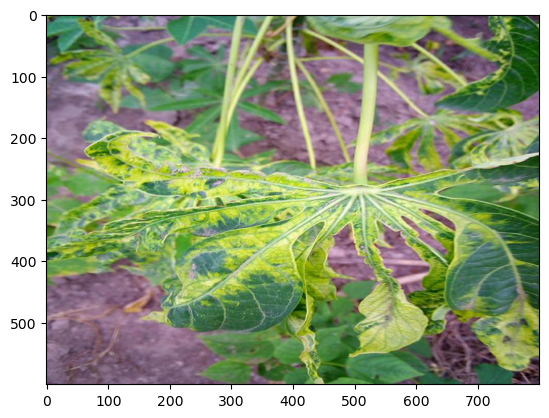

In [18]:
img = Image.open(r'C:\Users\MOJAHID HUSSAIN\Desktop\vit\cassava-leaf-disease-classification\train_images\6103.jpg')
fig = plt.figure()
plt.imshow(img)

In [19]:
# resize to imagenet size 
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

In [20]:
patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
# print(pathes.size())

In [22]:
# Path
Data_path=r'C:\Users\MOJAHID HUSSAIN\Desktop\vit\cassava-leaf-disease-classification'
training_images=r'C:\Users\MOJAHID HUSSAIN\Desktop\vit\cassava-leaf-disease-classification\train_images'
training_path=r'C:\Users\MOJAHID HUSSAIN\Desktop\vit\cassava-leaf-disease-classification\train.csv'
testing_path=r'C:\Users\MOJAHID HUSSAIN\Desktop\vit\cassava-leaf-disease-classification\test_images'

In [23]:
# Let look at the training data
wholeData=os.path.join(Data_path, "train.csv")
wholeData=pd.read_csv(wholeData)
wholeData.head()

# stratify ensures that the proportion of different classes in the original dataset is maintained in both the training and testing subsets.
training_data, valid_data=train_test_split(wholeData, test_size=0.2, random_state=42, stratify=wholeData.label.values) 
valid_data.head()

,image_id,label
10544,288080098.jpg,3
11634,3080364100.jpg,3
578,110051175.jpg,3
9118,2612067247.jpg,3
15857,3852927202.jpg,3


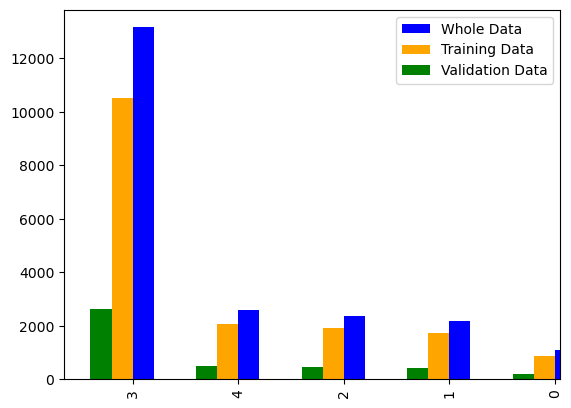

In [24]:
# split the data into training and validation data
import matplotlib.pyplot as plt
import seaborn as sns
wholeData.label.value_counts().plot(kind='bar', color='blue', position=0, width=0.20, label='Whole Data')
training_data.label.value_counts().plot(kind='bar', color='orange', position=1, width=0.20, label='Training Data')
valid_data.label.value_counts().plot(kind='bar', color='green', position=2, width=0.20, label='Validation Data')
plt.legend()
plt.show()

In [25]:
from PIL import Image

class CassavaDataset(torch.utils.data.Dataset):
    def __init__(self, wholeData, data_path=Data_path, transform=None, mode="train"):
        super().__init__()
        self.data=wholeData.values  #Covert df into 2D array
        self.data_path=data_path
        self.transform=transform
        self.mode=mode
        self.data_dir= "train_images" if mode=="train" else "test_images"
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image, label=self.data[index]
        image=os.path.join(self.data_path, self.data_dir, image);
        OpenImage=Image.open(image).convert("RGB")
        
        if self.transform is not None:
            OpenImage=self.transform(OpenImage)
        
        return OpenImage, label

In [26]:
image_size=224
from torchvision.transforms import transforms
transformsTrain=transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(10),
        transforms.RandomAffine(100),
        transforms.RandomResizedCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transformsValid = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [27]:
train_dataset= CassavaDataset(training_data, transform=transformsTrain) #train_dataset is a tensor array that contain all the training images at index 0 and its label at index 1 a/q to index
valid_dataset = CassavaDataset(valid_data, transform=transformsValid)
print(train_dataset[14][0].shape)

torch.Size([3, 224, 224])


In [28]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=48,
    shuffle=True,
    num_workers=4,
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=48,
    shuffle=False,
    num_workers=4,
)

In [29]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [30]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [31]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1) #concatenation
        # add position embedding
        x += self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

In [33]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [34]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

In [35]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [36]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 5):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [37]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 5,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [38]:
model=ViT()
print(model(x))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)

tensor([[ 0.0353,  0.0028, -0.8634,  0.0163, -1.3904]],
       grad_fn=<AddmmBackward0>)


In [39]:
batch_size=48
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    train_acc = 0
    
    for i, (data, target) in enumerate(train_loader):
        inputs, labels = data, target
        optimizer.zero_grad()
        outputs = model(inputs)
        train_acc += torch.sum(outputs.argmax(dim=1) == labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 20 == 0:
            last_loss = running_loss / 20 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(train_loader) + i + 1
            running_loss = 0.

    return train_acc/((len(train_loader)*batch_size))

In [ ]:
for i in range(10):
    print('Epoch: {}'.format(i + 1))
    out=train_one_epoch(i)
    print("Final:", out)

In [ ]:
def valid_check():
    running_loss = 0.
    last_loss = 0.
    train_acc = 0
    
    for i, (data, target) in enumerate(valid_loader):
        inputs, labels = data, target
        outputs = model(inputs)
        temp_acc = torch.sum(outputs.argmax(dim=1) == labels)
        train_acc+=temp_acc
        if i%10==0:
            print('  batch {} correct: {}'.format(i + 1, (train_acc/(batch_size*(i+1)))))

    return train_acc/(len(valid_loader)*batch_size)

In [ ]:
print("Final Accuracy:", valid_check())

In [41]:
# Model saving
epoch=5
PATH = r"C:\Users\MOJAHID HUSSAIN\Desktop\vit\model_checkpoint.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, PATH)

In [ ]:

model = ViT()
# optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = checkpoint['loss']

model.eval()